<a href="https://colab.research.google.com/github/palima1/text_processing/blob/main/C%C3%B3pia_01_ajustes_e_testes_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [345]:
!pip install contractions
!pip install textsearch
!pip install tqdm

In [346]:
#tratamentos iniciais
import pandas as pd
import numpy as np
#divisão dos dados
from sklearn.model_selection import train_test_split
#modelos baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score
#text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
# from nltk.tokenize import sent_tokenize (Tokenization)
from nltk.probability import FreqDist
from nltk.metrics import ConfusionMatrix
#visualização 
from wordcloud import WordCloud
import random
from matplotlib import pyplot as plt
# CNN
import os 
from bs4 import BeautifulSoup
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

In [347]:
df = pd.read_csv('/content/mouse.csv')

In [348]:
df.head()

,score,description,date
0,"1,0",O produto aparece usado...em baixo do aparelho...,13 de novembro de 2019
1,"5,0","Mouse sem fio ótimo, sem delay, nano receptor ...",19 de agosto de 2019
2,"3,0","A construção do mouse em si é boa, os clicks s...",15 de março de 2019
3,"5,0",A mídia não pôde ser carregada.\n ...,31 de julho de 2020
4,"1,0","O mouse está em boas condições, funcionando be...",21 de junho de 2020


# Pre-processing

### Contagem e remoção de dados nulos

In [349]:
df.isnull().sum()

score           0
description    18
date            0
dtype: int64

In [350]:
df.dropna(axis=0,inplace=True)

### Definição das categorias

In [351]:
def categoriza(dados):
    scores = []
    i = 0
    for dado in dados:
        if (dado == '1,0' or dado == '2,0'):
            scores.append(0)  #avaliação ruim
        if (dado =='3,0'):
            scores.append(1)  #avaliação ruim        
        if (dado == '4,0' or dado == '5,0'):
            scores.append(2) #avaliação boa
        i+=1
    return(scores)

In [352]:
#df['score'] = categoriza(df['score'])

In [353]:
df

,score,description,date
0,"1,0",O produto aparece usado...em baixo do aparelho...,13 de novembro de 2019
1,"5,0","Mouse sem fio ótimo, sem delay, nano receptor ...",19 de agosto de 2019
2,"3,0","A construção do mouse em si é boa, os clicks s...",15 de março de 2019
3,"5,0",A mídia não pôde ser carregada.\n ...,31 de julho de 2020
4,"1,0","O mouse está em boas condições, funcionando be...",21 de junho de 2020
...,...,...,...
4812,"5,0",A mídia não pôde ser carregada.,25 de março de 2022
4813,"5,0","ele é um pouco pequeno, mas tem uma resposta r...",23 de março de 2022
4814,"5,0","logitech né?! sem comentários, mouse maravilhoso",21 de março de 2022
4815,"5,0",Muito bom e bonito,17 de janeiro de 2022


### Divisão dos dados

In [354]:
y = df['score']
x = df.iloc[:,1]

#divisão do treino e teste

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

In [355]:
y_train.value_counts()

5,0    3311
4,0     322
1,0      90
3,0      70
2,0      47
Name: score, dtype: int64

In [356]:
y_test.value_counts()

5,0    828
4,0     81
1,0     22
3,0     17
2,0     12
Name: score, dtype: int64

### Resolvendo o desbalanceamento dos dados de treino

In [357]:
from imblearn.over_sampling import RandomOverSampler

In [358]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

In [359]:
print(X_resampled.shape)
print(y_resampled.shape)
print('\n',pd.DataFrame(y_resampled).value_counts())

(16555, 1)
(16555,)

 1,0    3311
2,0    3311
3,0    3311
4,0    3311
5,0    3311
dtype: int64


In [360]:
X_train , y_train = pd.DataFrame(X_resampled), y_resampled

In [361]:
X_train = np.array(X_train[0])

### Tokenização

In [362]:
def tokenizador(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [363]:
X_train = tokenizador(X_train)
X_test = tokenizador(X_test)

### Padronização de algumas escritas

In [364]:
def padroniza_caracteres(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [365]:
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também',
            'obg': 'obrigado', 'gnt': 'gente', 'q': 'que', 'n': 'não', 'cmg': 'comigo',
            'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'}

In [366]:
X_train = padroniza_caracteres(X_train,std_list)
X_test = padroniza_caracteres(X_test,std_list)

### Remoção de stop words

In [367]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [368]:
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')

In [369]:
pontos = ['!','.',',',':',';']

for sinal in pontos:
    nltk_stopwords.append(sinal)

In [370]:
nltk_stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [371]:
def removedor_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [372]:
X_train = removedor_stopwords(X_train, nltk_stopwords)
X_test = removedor_stopwords(X_test, nltk_stopwords)

# Stemmer

In [373]:
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [374]:
def aplica_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [375]:
X_train_stem = aplica_stemmer(X_train)
X_test_stem = aplica_stemmer(X_test)

### Visualizações iniciais

In [376]:
def texto_para_cloud(tokens):
    text = ''

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            text += word + ' '
        
    return text

In [377]:
x2=tokenizador(x)

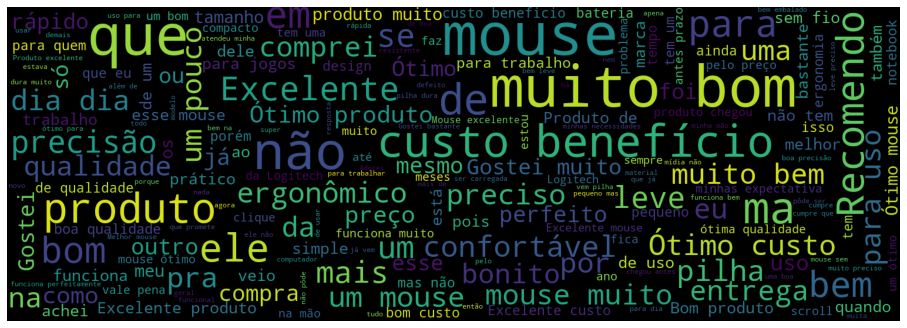

In [378]:
text_cloud = texto_para_cloud(random.sample(x2, 3000))

word_cloud = WordCloud(max_font_size = 100, width = 1520, height = 535)
word_cloud.generate(text_cloud)
plt.figure(figsize = (16, 9))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Frequencias

In [379]:
def pega_freq(tokens):
    ls = []

    for tk_line in tokens:
        for word in tk_line:
            ls.append(word)

    return ls

In [380]:
# Frequency Distribution on training dataset
fd_list = pega_freq(X_train_stem)
fdist = FreqDist(fd_list)
print(fdist)

# most common words
most_common = fdist.most_common(25)
print(most_common,'\n')

<FreqDist with 2294 samples and 240436 outcomes>
[('mous', 9756), ('produt', 5656), ('bom', 4243), ('compr', 3870), ('uso', 3272), ('bem', 3113), ('precis', 2942), ('funcion', 2493), ('func', 2019), ('pilh', 1953), ('vei', 1845), ('dia', 1727), ('mes', 1713), ('gost', 1690), ('problem', 1674), ('pouc', 1668), ('marc', 1654), ('rol', 1647), ('us', 1624), ('ser', 1594), ('ótim', 1475), ('pra', 1472), ('scroll', 1449), ('outr', 1446), ('boa', 1429)] 



In [381]:
most_uncommon = fdist.hapaxes()
print(most_uncommon[0:30])

['folh', 'ocasion', 'frent', 'conexa', 'percerb', 'tamb', 'simplific', 'acert', 'repost', 'exccel', 'muitaqual', 'custoxbenefici', 'satifeit', 'afirm', 'book', 'adi', 'baixiss', 'morr', '💛', 'vá', 'competitiv', 'segment', 'desvant', 'natur', 'execuç', 'educ', 'prestígi', 'dalay', 'exclusiv', 'altiss']


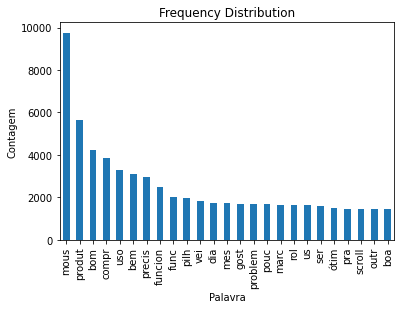

In [382]:
# print most common words
series = pd.Series(data=[v for k, v in most_common], index=[k for k, v in most_common], name='')
ax = series.plot(kind='bar', title='Frequency Distribution')
ax.set_xlabel('Palavra')
ax.set_ylabel('Contagem')
plt.show()

# Destransformando
- Após o tratamento dos dados, com o uso do nltk, voltaremos os mesmos para o formato inicial, de string

In [383]:
def _untokenize_text(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [384]:
X_train = _untokenize_text(X_train)
X_test = _untokenize_text(X_test)

In [385]:
X_train_stem = _untokenize_text(X_train_stem)
X_test_stem = _untokenize_text(X_test_stem)

## Baseline - Bag of words/Naive Bayes

In [386]:
vetores = CountVectorizer()
#vetores2 = CountVectorizer()

In [387]:
X_train = vetores.fit_transform(X_train)
X_train = X_train.toarray()

In [388]:
X_test = vetores.transform(X_test)
X_test =  X_test.toarray()

print(X_train.shape)
print(X_test.shape)

(16555, 3717)
(960, 3717)


In [389]:
print(X_train.shape)
print(X_test.shape)

(16555, 3717)
(960, 3717)


In [390]:
modelo_1 = MultinomialNB()
modelo_1.fit(X_train,y_train)

MultinomialNB()

In [391]:
predict = modelo_1.predict(X_test)

In [392]:
metrics.accuracy_score(predict, y_test)

0.7739583333333333

In [393]:
test = ['Melhor mouse do brasil',
       'Péssimo mouse horrivel',
       'mais ou menos, mas dá pra usar',
       'compensa, entrega o que promete, mas nada muito além disso']

In [394]:
test = tokenizador(test)
test = padroniza_caracteres(test, std_list)
test = removedor_stopwords(test,nltk_stopwords)
test = _untokenize_text(test)

In [395]:
vetor_test = vetores.transform(test)
vetor_test = vetor_test.toarray()

In [396]:
vetor_test.shape

(4, 3717)

In [397]:
modelo_1.predict(vetor_test)

array(['4,0', '2,0', '2,0', '4,0'], dtype='<U3')

In [398]:
print(metrics.classification_report(y_test,predict))

              precision    recall  f1-score   support

         1,0       0.42      0.50      0.46        22
         2,0       0.13      0.17      0.15        12
         3,0       0.00      0.00      0.00        17
         4,0       0.22      0.41      0.29        81
         5,0       0.92      0.84      0.88       828

    accuracy                           0.77       960
   macro avg       0.34      0.38      0.36       960
weighted avg       0.83      0.77      0.80       960



In [399]:
resultados = cross_val_score(modelo_1, X_train, y_train, cv = 10)

In [400]:
print(resultados)

[0.87983092 0.87681159 0.87922705 0.86835749 0.87137681 0.87432024
 0.86586103 0.86646526 0.88277946 0.87009063]


## Random Forest

In [401]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)

In [402]:
forest.fit(X_train,y_train)

RandomForestClassifier()

In [403]:
print(metrics.classification_report(y_test,forest.predict(X_test)))

              precision    recall  f1-score   support

         1,0       0.40      0.27      0.32        22
         2,0       0.00      0.00      0.00        12
         3,0       0.00      0.00      0.00        17
         4,0       0.08      0.10      0.09        81
         5,0       0.87      0.89      0.88       828

    accuracy                           0.78       960
   macro avg       0.27      0.25      0.26       960
weighted avg       0.76      0.78      0.77       960



In [404]:
(98+0+34)/3

44.0

## LSTM


LSTM based Text Classification

CNN + LSTM based Text Classification

In [405]:
# call load_data with allow_pickle implicitly set to true
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size = 0.2)
print("Shape of train data:", X_train.shape)
print("Shape of Test data:", X_test.shape)
print("Shape of CV data:", X_cv.shape)

# truncate and pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
X_cv = sequence.pad_sequences(X_cv,maxlen=max_review_length)

Shape of train data: (13244, 3717)
Shape of Test data: (960, 3717)
Shape of CV data: (3311, 3717)


In [406]:
import tensorflow as tf

# Write the code for LSTM Based Classifcation
# Embedding layer
# LSTM Layer : You are free to choose the hyperparameters and the number of layers
# Dense Layer

# load the dataset but only keep the top n words, zero the rest
top_words = 10000

# Students will be starting their code from here:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
model.add(LSTM(200))
model.add(Dense(units=3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Change the number of epochs and the batch size depending on the RAM Size

history = model.fit(X_train, y_train, epochs=5, batch_size=64,verbose = 1,validation_data=(X_cv,y_cv))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 600, 32)           320000    
                                                                 
 lstm_13 (LSTM)              (None, 200)               186400    
                                                                 
 dense_13 (Dense)            (None, 3)                 603       
                                                                 
Total params: 507,003
Trainable params: 507,003
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


UnimplementedError: ignored

In [ ]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
show_train_history(history,'accuracy','val_accuracy')
show_train_history(history,'loss','val_loss')

In [ ]:
print('Training loss \t', history.history['loss'][-1]*100)
print('Training accuracy ',  history.history['accuracy'][-1]*100)
print('Validation loss ', history.history['val_loss'][-1]*100)
print('Validation accuracy ',  history.history['val_accuracy'][-1]*100)



In [ ]:
# Final evaluation of the model using test dataset
# Students will be starting their code from here:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Testing loss \t', scores[0]*100)
print('Testing accuracy ', scores[1]*100)

In [ ]:
# create the model
embedding_vector_length = 32
cnn_model = Sequential()

# Students will be starting their code from here:

# Write the code for LSTM Based Classifcation
# Embedding layer
# Convolution-1D Layer : You are free to choose the hyperparameters and the number of layers
# LSTM Layer : You are free to choose the hyperparameters and the number of layers
# Dense Layer

cnn_model.add(Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_review_length))
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(LSTM(100))
cnn_model.add(Dense(units=3, activation='softmax'))

# Students will be ending their code here

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_model.summary())

# Change the number of epochs and the batch size depending on the RAM Size

history_c=cnn_model.fit(X_train, y_train, epochs=5, batch_size=64,verbose = 1,validation_data=(X_cv,y_cv))

In [ ]:
# Final evaluation of the CNN + RNN model using the test data
# Students will be starting their code from here:
show_train_history(history_c,'accuracy','val_accuracy')
show_train_history(history_c,'loss','val_loss')

print('Training loss \t', history_c.history['loss'][-1]*100)
print('Training accuracy ',  history_c.history['accuracy'][-1]*100)
print('Validation loss ', history_c.history['val_loss'][-1]*100)
print('Validation accuracy ',  history_c.history['val_accuracy'][-1]*100)

In [ ]:
# Final evaluation of the model using test dataset
# Students will be starting their code from here:

cnn_scores = cnn_model.evaluate(X_test, y_test, verbose=1)
print('Testing loss \t', scores[0]*100)
print('Testing accuracy ', scores[1]*100)

## Comparing the models

In [ ]:
#Creating a function to display values:
def show_values_on_bars(axs, h_v="v", space=0.2):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = "{:.2f}".format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = "{:.2f}".format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)



In [ ]:
#Creating a dataframe to draw out comparisons

import seaborn as sns
import pandas as pd

results=[]
results.append([scores[0], 'Loss', 'LSTM'])
results.append([scores[1], 'Accuracy', 'LSTM'])
results.append([cnn_scores[0], 'Loss', 'CNN+LSTM'])
results.append([cnn_scores[1], 'Accuracy', 'CNN+LSTM'])


comparison = pd.DataFrame(results, columns = ['Score', 'Metric', 'Model'])

plt.figure(figsize=(10,10))
plot = sns.barplot(x=comparison['Metric'],y=comparison['Score'], hue = comparison['Model'])

show_values_on_bars(plot)